In [1]:
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from collections import Counter
import sklearn
from sklearn import preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib as mpl
import sklearn
from sklearn.metrics import confusion_matrix
#SCF received from Floyd 6 April 2022.
# with note: Here is a better script than the one we were going through earlier. It is the same basic architecture (not ccn) but uses class weights and has some handy functions for plotting roc and precision-recall curve

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#put your path to the dataset here 
#SCF: I had to overwrite this with my path to get it to work. Is that breaking the code for you Floyd?
# SCF: The "index" column has the format i:jPDB. Wouldn't it be easier to parse and sort in the format i,j,PDB ?
#FJ: you can use the 'file' column if you want to sort by file. it is the second to last colun in the df 
df = pd.read_csv('/content/drive/MyDrive/deep-learning-RNA-structure-prediction/Floyd_Scripts_and_Figs/labeleddinucfreq_march25.csv', index_col =0)


In [ ]:
df.drop('16:446HAG', inplace = True) #uncommon residue SAH  101  on chain A [#44] assigned to: a - I dont know what this is but is says this in 6hag.pdb.out it is not a contact so remove

In [4]:
#drop these 14 MSA's as they dont match between RFAM and PDB sequences so labels are wrong
#SCF: Kaouther points out that some of these differneces in length between msa and pdb are only one residue. coudl easily be manually fixed.
df = df[df["file"].str.contains('2H0S|4P5J|4QLN|4RUM|6CB3|6FZ0|1NBS|1FFZ|1U9S|2IL9|3F2Q|4RZD|4Y1O|6CU1') == False]


In [5]:
y = df['bond_type'] #set labels
y.replace([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], 1, inplace = True) #make binary so only contact or not contact
X = df.drop(['positions','file','bond_type'], axis = 1) #set data 

In [6]:
#see data set balance between contact and not toncat 
neg, pos = np.bincount(df['bond_type'])
total = neg + pos
print('Examples:\n    Total: {}\n    Contacts: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1169879
    Contacts: 3946 (0.34% of total)



In [7]:
#set class weights 
#SCF: seems like a reasonable weighting scheme.

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 148.24


In [8]:
#splits train and test. This splits randomly on all data rather than by MSA, so leads to overtraining.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
#function for plotting confusion matrix 

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

 

In [10]:
#function for plotting prc

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall- TP / (TP + FN)')
    plt.ylabel('Precision- TP / (TP + FP)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [11]:
#function for plotting roc 
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives Rate - FP/(FP + TN)')
  plt.ylabel('True positives Rate - TP/(TP + FN)')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [27]:
#make the model 

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  print("X_train.shape[-1] = ",X_train.shape[-1])
  model = keras.Sequential([
      keras.layers.Dense( # add a single dense layer
          25, activation='relu',
          input_shape=(X_train.shape[-1],)), # X_train.shape[-1] returns 25. with 20 epochs, accuracy: 0.8337 - precision: 0.0106
      #keras.layers.Dropout(0.5), # after removing this line, at 20 epochs: 
      keras.layers.Dense(1, activation='sigmoid'), #this is the output layer with a single neuron
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [28]:
#set epochs, batch size, and early stopping to prevent overfitting based on the PRC
#can only use early stopping if you have a validation set since you must monitor the performance on train and validation.
#i did not use a validation set in this simple model. 
EPOCHS = 20 # was 100
BATCH_SIZE = 2048
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_prc', 
#     verbose=1,
#     patience=10,
#     mode='max',
#     )

In [29]:
#train the model 
model = make_model()
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks = [early_stopping], #turn this on if you are using a validation set
    class_weight = {0: 0.50, 1: 148.24})
    

X_train.shape[-1] =  25
Epoch 1/20
400/400 [==============================] - 5s 4ms/step - loss: 0.6501 - tp: 1557.0000 - fp: 257544.0000 - tn: 558599.0000 - fn: 1215.0000 - accuracy: 0.6840 - precision: 0.0060 - recall: 0.5617 - auc: 0.6651 - prc: 0.0097
Epoch 2/20
400/400 [==============================] - 2s 6ms/step - loss: 0.6139 - tp: 1575.0000 - fp: 222806.0000 - tn: 593337.0000 - fn: 1197.0000 - accuracy: 0.7265 - precision: 0.0070 - recall: 0.5682 - auc: 0.7103 - prc: 0.0151
Epoch 3/20
400/400 [==============================] - 4s 10ms/step - loss: 0.6056 - tp: 1465.0000 - fp: 182349.0000 - tn: 633794.0000 - fn: 1307.0000 - accuracy: 0.7757 - precision: 0.0080 - recall: 0.5285 - auc: 0.7177 - prc: 0.0186
Epoch 4/20
400/400 [==============================] - 4s 9ms/step - loss: 0.6021 - tp: 1513.0000 - fp: 187273.0000 - tn: 628870.0000 - fn: 1259.0000 - accuracy: 0.7698 - precision: 0.0080 - recall: 0.5458 - auc: 0.7202 - prc: 0.0196
Epoch 5/20
400/400 [=======================

In [17]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.5587644577026367
tp :  630.0
fp :  55730.0
tn :  294060.0
fn :  544.0
accuracy :  0.839658796787262
precision :  0.01117814052850008
recall :  0.536626935005188
auc :  0.7627354264259338
prc :  0.0673341304063797



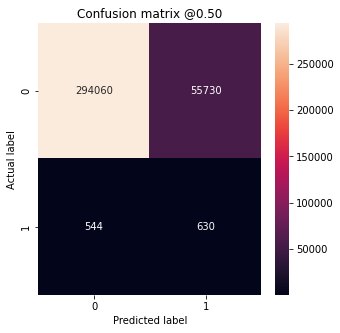

In [18]:
results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions)

In [19]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

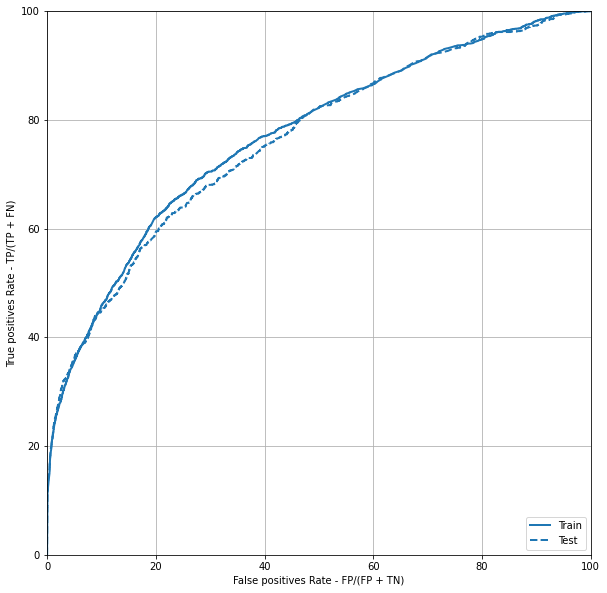

In [20]:
plot_roc("Train", y_train, train_predictions, color=colors[0])
plot_roc("Test", y_test, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

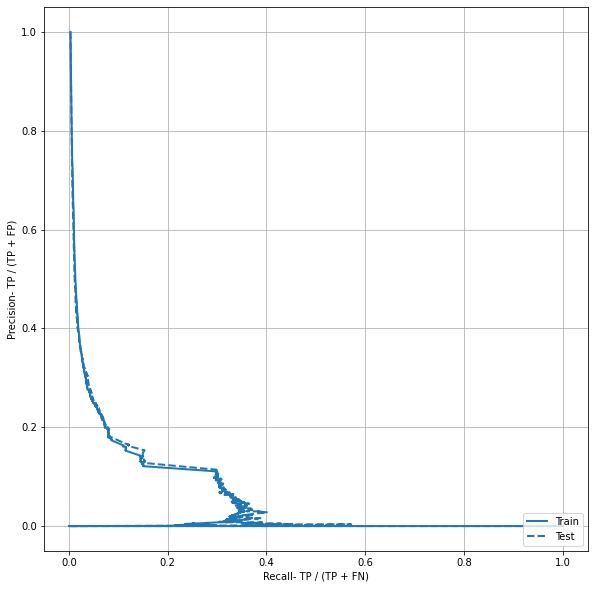

In [ ]:
plot_prc("Train", y_train, train_predictions, color=colors[0])
plot_prc("Test", y_test, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');